In [65]:
# Import data
from __future__ import division
import math
import pylab
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import pandas as pd

# magnetometer uncalibrated

df = pd.read_csv('raw_data_ios_1082_12-44-29_np.csv', sep = ' ', header = None) # train dataset
df.columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z', 'ts', 'zone_nbr']
df['ts'] = df.index
#df.ts = df.ts * 0.05
df.tail()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,ts,zone_nbr
2321,1010.648010,-20.252001,-14.030,-7000.0,-2730.0,700.0,597.520020,130.619995,1049.020020,2321,15.0
2322,1012.234009,-20.984001,-14.396,-7070.0,-2590.0,560.0,603.820007,132.020004,1044.400024,2322,15.0
2323,1013.210022,-21.228001,-14.640,-7210.0,-3150.0,700.0,594.299988,129.500000,1057.560059,2323,15.0
2324,1010.892029,-20.984001,-14.396,-7350.0,-2730.0,700.0,593.320007,135.800003,1044.819946,2324,15.0
2325,1012.234009,-20.130001,-15.250,-7210.0,-2660.0,630.0,594.440002,132.580002,1052.520020,2325,15.0


In [60]:
# Check time spent in zones

zone_cnts = pd.DataFrame(df['zone_nbr'].value_counts())
zone_cnts.columns = ['count_rows'] 
zone_cnts['zone_nbr'] = zone_cnts.index
zone_cnts.count_rows = zone_cnts.count_rows * 0.05
zone_cnts.sort_values(by=['zone_nbr']).T

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0
count_rows,3.65,7.7,7.5,7.5,7.5,7.45,7.5,7.5,7.5,7.5,7.5,7.55,7.45,7.5,7.5,7.45
zone_nbr,0.00,1.0,2.0,3.0,4.0,5.00,6.0,7.0,8.0,9.0,10.0,11.00,12.00,13.0,14.0,15.00


In [61]:
np.sum(zone_cnts.count_rows) # check that the ts adds up to end time

116.25000000000001

In [66]:
from definitions import zone_df

# Merge zone information
zdf = zone_df()
df = pd.merge(df, zdf, how = 'inner', on = 'zone_nbr')
#df.tail()

In [2]:
from definitions import transform_units_no_sens_agm

# accelero with sensitivity, gyr with no sensitivity, mag with no calibration

# Apply calibrations and sensitivity
pdf = transform_units_no_sens_agm(df)
pdf.tail()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,ts,zone_nbr,acc_norm,acc_x_norm,acc_y_norm,acc_z_norm,mag_norm,mag_x_norm,mag_y_norm,mag_z_norm
2321,1.010648,-0.020252,-0.014030,-490.0,-191.1,49.0,5.042991,202.012861,745.910553,119740.0,15.0,1.010948,0.999703,-0.020033,-0.013878,772.798279,0.006526,0.261404,0.965207
2322,1.012234,-0.020984,-0.014396,-494.9,-181.3,39.2,13.861791,204.877681,742.738726,119790.0,15.0,1.012554,0.999684,-0.020724,-0.014218,770.602251,0.017988,0.265867,0.963842
2323,1.013210,-0.021228,-0.014640,-504.7,-220.5,49.0,0.970501,199.703935,752.211075,119823.0,15.0,1.013538,0.999676,-0.020944,-0.014444,778.269944,0.001247,0.256600,0.966517
2324,1.010892,-0.020984,-0.014396,-514.5,-191.1,49.0,-1.078422,210.145696,742.362971,119890.0,15.0,1.011212,0.999683,-0.020751,-0.014236,771.534288,-0.001398,0.272374,0.962191
2325,1.012234,-0.020130,-0.015250,-504.7,-186.2,44.1,0.949633,204.817521,748.329447,119940.0,15.0,1.012549,0.999689,-0.019881,-0.015061,775.853131,0.001224,0.263990,0.964525


In [3]:
def angles_comp(df):
    dt = 0.05 # usually 20 ms sample rate, 50 HZ, or 1/50 = 0.02
    shape_y = df.shape[0]

    # set values
    accX = df['acc_x']
    accY = df['acc_y']
    accZ = df['acc_z']

    gyrX = df['gyr_x']
    gyrY = df['gyr_y']
    gyrZ = df['gyr_z']

    angles_df = pd.DataFrame()

    mu = 0.1

    roll = -gyrX.iloc[0] * dt
    pitch = -gyrY.iloc[0] * dt
    gyr_angle_z = -gyrZ.iloc[0] * dt

    roll_acc = (math.atan2(float(accY.iloc[0]),
                           float(math.sqrt(
                               mu * (accX.iloc[0] * accX.iloc[0]) + accZ.iloc[0] * accZ.iloc[0])))) * 180 / math.pi

    pitch_acc = (math.atan2(float(-1*accX.iloc[0]),
                            float(
                                math.sqrt(accY.iloc[0] * accY.iloc[0] + accZ.iloc[0] * accZ.iloc[0])))) * 180 / math.pi

    acc_z_tilt = math.atan2(float(accZ.iloc[0]), float(math.sqrt(
        accX.iloc[0] * accX.iloc[0] + accY.iloc[0] * accY.iloc[0] + accZ.iloc[0] * accZ.iloc[0]))) * 180 / math.pi

    angles = pd.Series([roll, pitch, gyr_angle_z, roll_acc, pitch_acc, acc_z_tilt, gyrX.iloc[0], gyrY.iloc[0], gyrZ.iloc[0], accX.iloc[0], accY.iloc[0], accZ.iloc[0]],
                       ['gyr_roll_x', 'gyr_pitch_y', 'gyr_angle_z', 'acc_roll_x', 'acc_pitch_y',
                        'acc_angle_z', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_x', 'acc_y', 'acc_z'])

    angles_df = angles_df.append([angles], ignore_index=True)

    for i, j in zip(range(1, shape_y), range(1, shape_y)):

        # Integrate the gyroscope data -> int(angularSpeed) = angle, quick and dirty way

        roll += -gyrX.iloc[j] * dt;
        pitch += -gyrY.iloc[j] * dt;
        gyr_angle_z += -gyrZ.iloc[j] * dt;

        if pitch > 90:
            pitch -= 180
        elif pitch < -90:
            pitch += 180

        if roll > 90:
            roll -= 180
        elif roll < -90:
            roll += 180

        # Accelerometer angles calculation

        # X axis rotation - roll
        roll_acc = (math.atan2(float(accY.iloc[i]),
                               float(math.sqrt(
                                   mu * (accX.iloc[i] * accX.iloc[i]) + accZ.iloc[i] * accZ.iloc[i])))) * 180 / math.pi

        # Y axis rotation - pitch
        pitch_acc = (math.atan2(float(-1*accX.iloc[i]), float(math.sqrt(
            accY.iloc[i] * accY.iloc[i] + accZ.iloc[i] * accZ.iloc[
                i])))) * 180 / math.pi  # arctan(-Gpx / sqrt(Gpy^2 + Gpz^2))

        # Tilt angle Z - if no linear acc
        acc_z_tilt = math.atan2(float(accZ.iloc[i]), float(math.sqrt(
            accX.iloc[i] * accX.iloc[i] + accY.iloc[i] * accY.iloc[i] + accZ.iloc[i] * accZ.iloc[i]))) * 180 / math.pi
        # arctan(Gpz/ sqrt(Gpx^2 + Gpy^2 + Gpz^2))


        angles = pd.Series([roll, pitch, gyr_angle_z, roll_acc, pitch_acc, acc_z_tilt, gyrX.iloc[i], gyrY.iloc[i], gyrZ.iloc[i], accX.iloc[i], accY.iloc[i], accZ.iloc[i]],
                           ['gyr_roll_x', 'gyr_pitch_y', 'gyr_angle_z', 'acc_roll_x', 'acc_pitch_y',
                            'acc_angle_z', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_x', 'acc_y', 'acc_z'])

        angles_df = angles_df.append([angles], ignore_index=True)

    return (angles_df)


In [4]:
cdf = angles_comp(pdf)
cdf.tail()

,gyr_roll_x,gyr_pitch_y,gyr_angle_z,acc_roll_x,acc_pitch_y,acc_angle_z,gyr_x,gyr_y,gyr_z,acc_x,acc_y,acc_z
2321,-57.415,14.820,-5424.790,-3.622375,-88.603550,-0.795103,-490.0,-191.1,49.0,1.010648,-0.020252,-0.014030
2322,-32.670,23.885,-5426.750,-3.746895,-88.559893,-0.814549,-494.9,-181.3,39.2,1.012234,-0.020984,-0.014396
2323,-7.435,34.910,-5429.200,-3.786574,-88.542104,-0.827548,-504.7,-220.5,49.0,1.013210,-0.021228,-0.014640
2324,18.290,44.465,-5431.650,-3.751845,-88.557982,-0.815629,-514.5,-191.1,49.0,1.010892,-0.020984,-0.014396
2325,43.525,53.775,-5433.855,-3.594371,-88.570820,-0.862866,-504.7,-186.2,44.1,1.012234,-0.020130,-0.015250


In [5]:
from pykalman import KalmanFilter
import math

def kalman_filter(df):
    dt = 0.05
    df = df[:-1]

    meas_list_x = []
    for i in range(0, df.shape[0]):
        n = [df.acc_roll_x[i], df.gyr_x[i]]
        meas_list_x.append(n)

    meas_list_y = []
    for i in range(0, df.shape[0]):
        n = [df.acc_pitch_y[i], df.gyr_y[i]]
        meas_list_y.append(n)

    # State transition matrix
    A = [[1, -dt],
         [0, 1]]

    # Observation matrix
    H = [[1, 0.0], [0.0, 1]]

    # Transition covariance matrix - process
    q = 0.001
    #q = 0.01
    Q = np.matrix([[q, 0.0], [0.0, q]])

    # Observation covariance matrix - meas
    # R = np.matrix([[saccY**2, 0.0], [0.0, sgyrY**2]])
    r = 0.05
    #r = 8.
    R = np.matrix([[r, 0.0], [0.0, r]])

    # Kalman filter on x-axis
    kfx = KalmanFilter(transition_matrices=A, observation_matrices=H, transition_covariance=Q, observation_covariance=R)
    measurements_x = np.array(meas_list_x)  # 2 observations
    kfx = kfx.em(measurements_x, n_iter=5)
    (filtered_state_means_x, filtered_state_covariances_x) = kfx.filter(measurements_x)
    # (smoothed_state_means, smoothed_state_covariances) = kfx.smooth(measurements)

    # Kalman filter on y-axis
    kfy = KalmanFilter(transition_matrices=A, observation_matrices=H, transition_covariance=Q, observation_covariance=R)
    measurements_y = np.array(meas_list_y)  # 2 observations
    kfy = kfy.em(measurements_y, n_iter=5)
    (filtered_state_means_y, filtered_state_covariances_y) = kfy.filter(measurements_y)
    # (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

    data_plot_x = []
    gyr_angle = meas_list_x[0][0]
    for i in range(len(meas_list_x)):
        gyr_angle += -dt * meas_list_x[i][1]
        n = [meas_list_x[i][0], gyr_angle, filtered_state_means_x[i, 0]]
        data_plot_x.append(n)

    val_dfx = pd.DataFrame(data_plot_x)
    val_dfx.columns = ['rot_angle_x', 'gyr_meas_x', 'kalman_filt_x']
    val_dfx['ts'] = val_dfx.index

    data_plot_y = []
    gyr_angle = meas_list_y[0][0]
    for i in range(len(meas_list_y)):
        gyr_angle += -dt * meas_list_y[i][1]
        n = [meas_list_y[i][0], gyr_angle, filtered_state_means_y[i, 0]]
        data_plot_y.append(n)

    val_dfy = pd.DataFrame(data_plot_y)
    val_dfy.columns = ['rot_angle_y', 'gyr_meas_y', 'kalman_filt_y']
    val_dfy['ts'] = val_dfy.index

    val_df = pd.merge(val_dfx, val_dfy, how='inner', on='ts')

    return val_df

In [6]:
kdf = kalman_filter(cdf)
kdf.tail()

,rot_angle_x,gyr_meas_x,kalman_filt_x,ts,rot_angle_y,gyr_meas_y,kalman_filt_y
2320,-3.705413,57334.049886,-1.257430,2320,-88.554464,23136.666292,-87.623485
2321,-3.622375,57358.549886,-1.145114,2321,-88.603550,23146.221292,-87.645186
2322,-3.746895,57383.294886,-1.246368,2322,-88.559893,23155.286292,-87.608738
2323,-3.786574,57408.529886,-1.300431,2323,-88.542104,23166.311292,-87.652696
2324,-3.751845,57434.254886,-1.281243,2324,-88.557982,23175.866292,-87.626257


In [7]:
def mag_yaw(df):
    # Equations to transform magnetometer to horizontal plane
    # Y = pitch angle in radians, X = roll angle in radians
    # Xh = mag_x*cos(Y)+mag_y*sin(Y)sin(X)+mag_z*sin(Y)*cos(X)
    # -Yh = mag_z*sin(X)-mag_y*cos(X)
    # yaw = atan2(-Yh/Xh) to get results between - pi and pi

    shape_y = df.shape[0]

    mag_x = df['mag_x_norm']
    mag_y = df['mag_y_norm']
    mag_z = df['mag_z_norm']

    roll = df['kalman_filt_x'] * math.pi / 180  # roll radians
    pitch = df['kalman_filt_y'] * math.pi / 180  # pitch radians

    angles_df = pd.DataFrame()

    # -Yh
    Yh = mag_z.iloc[0] * math.sin(roll.iloc[0]) - mag_y.iloc[0] * math.cos(roll.iloc[0])

    # Xh
    Xh = mag_x.iloc[0] * math.cos(pitch.iloc[0]) + mag_y.iloc[0] * math.sin(pitch.iloc[0]) * math.sin(roll.iloc[0]) + mag_z.iloc[0] * math.sin(pitch.iloc[0]) * math.cos(roll.iloc[0])

    yaw = -(math.atan2(float(Yh), float(Xh))) * (180 / math.pi)

    yaw_simple = (math.atan2(float(mag_y.iloc[0]), float(mag_x.iloc[0]))) * (180 / math.pi)

    angles0 = pd.Series([df.rot_angle_x.iloc[0], df.gyr_meas_x.iloc[0], df.kalman_filt_x.iloc[0],
                         df.rot_angle_y.iloc[0], df.gyr_meas_y.iloc[0], df.kalman_filt_y.iloc[0],
                         yaw, Xh, Yh, df.mag_x_norm.iloc[0], df.mag_y_norm.iloc[0], df.mag_z_norm.iloc[0], yaw_simple],
                        ['acc_angle_x', 'gyr_angle_x', 'kalman_roll',
                         'acc_angle_y', 'gyr_angle_y', 'kalman_pitch',
                         'yaw', 'Xh', 'Yh', 'mag_x_norm', 'mag_y_norm', 'mag_z_norm', 'yaw_simple'])

    angles_df = angles_df.append([angles0], ignore_index=True)

    for i in range(1, shape_y):
        # Calculate headings on each axis

        # -Yh
        Yh += mag_z.iloc[i] * math.sin(roll.iloc[i]) - mag_y.iloc[i] * math.cos(roll.iloc[i])

        # Xh
        Xh += mag_x.iloc[i] * math.cos(pitch.iloc[i]) + mag_y.iloc[i] * math.sin(pitch.iloc[i]) * math.sin(roll.iloc[i]) + mag_z.iloc[i] * math.sin(pitch.iloc[i]) * math.cos(roll.iloc[i])

        # Compute yaw

        yaw = -(math.atan2(float(Yh), float(Xh))) * (180 / math.pi)  # add magnetic declination for paris, +1.61 ?

        yaw_simple = (math.atan2(float(mag_y.iloc[i]), float(mag_x.iloc[i]))) * (180 / math.pi)

        # print(Xh, Yh, yaw)

        angles = pd.Series([df.rot_angle_x.iloc[i], df.gyr_meas_x.iloc[i], df.kalman_filt_x.iloc[i],
                            df.rot_angle_y.iloc[i], df.gyr_meas_y.iloc[i], df.kalman_filt_y.iloc[i],
                            yaw, Xh, Yh, df.mag_x_norm.iloc[i], df.mag_y_norm.iloc[i], df.mag_z_norm.iloc[i], yaw_simple],
                           ['acc_angle_x', 'gyr_angle_x', 'kalman_roll',
                            'acc_angle_y', 'gyr_angle_y', 'kalman_pitch',
                            'yaw', 'Xh', 'Yh', 'mag_x_norm', 'mag_y_norm', 'mag_z_norm', 'yaw_simple'])

        angles_df = angles_df.append([angles], ignore_index=True)

    return angles_df

In [8]:
# Tilt-compensated yaw 
mags_df = pdf[['mag_x', 'mag_x', 'mag_y', 'mag_z', 'mag_x_norm', 'mag_y_norm', 'mag_z_norm', 'ts']]
mags_df['ts'] = mags_df.index
mags_df = pd.merge(kdf, mags_df, how = 'inner', on = 'ts')


vals_df = mag_yaw(mags_df)
vals_df['ts'] = vals_df.index
#vals_df = pd.merge(vals_df, df[['ts', 'zone_nbr', 'zone_name', 'quad_nbr', 'quad_name']], how = 'inner', on = 'ts')
vals_df.tail()

c:\users\amu277\anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,acc_angle_x,gyr_angle_x,kalman_roll,acc_angle_y,gyr_angle_y,kalman_pitch,yaw,Xh,Yh,mag_x_norm,mag_y_norm,mag_z_norm,yaw_simple,ts
2320,-3.705413,57334.049886,-1.257430,-88.554464,23136.666292,-87.623485,151.896406,-1319.458668,-704.631685,0.004634,0.270388,0.962740,89.018105,2320
2321,-3.622375,57358.549886,-1.145114,-88.603550,23146.221292,-87.645186,151.904217,-1320.417380,-704.912326,0.006526,0.261404,0.965207,88.569982,2321
2322,-3.746895,57383.294886,-1.246368,-88.559893,23155.286292,-87.608738,151.911767,-1321.373626,-705.199096,0.017988,0.265867,0.963842,86.129332,2322
2323,-3.786574,57408.529886,-1.300431,-88.542104,23166.311292,-87.652696,151.919647,-1322.333214,-705.477564,0.001247,0.256600,0.966517,89.721562,2323
2324,-3.751845,57434.254886,-1.281243,-88.557982,23175.866292,-87.626257,151.926919,-1323.288311,-705.771385,-0.001398,0.272374,0.962191,90.294027,2324


In [26]:
vals_dfz = pd.merge(vals_df, df, how = 'inner', on = 'ts')
vals_dfz.tail()

,acc_angle_x,gyr_angle_x,kalman_roll,acc_angle_y,gyr_angle_y,kalman_pitch,yaw,Xh,Yh,mag_x_norm,...,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,zone_nbr,quad_name,quad_nbr,zone_name
2320,-3.705413,57334.049886,-1.257430,-88.554464,23136.666292,-87.623485,151.896406,-1319.458668,-704.631685,0.004634,...,-7350.0,-2940.0,560.0,595.840027,136.779999,1058.680054,15.0,Inc_int,5,Lo_inc_int
2321,-3.622375,57358.549886,-1.145114,-88.603550,23146.221292,-87.645186,151.904217,-1320.417380,-704.912326,0.006526,...,-7000.0,-2730.0,700.0,597.520020,130.619995,1049.020020,15.0,Inc_int,5,Lo_inc_int
2322,-3.746895,57383.294886,-1.246368,-88.559893,23155.286292,-87.608738,151.911767,-1321.373626,-705.199096,0.017988,...,-7070.0,-2590.0,560.0,603.820007,132.020004,1044.400024,15.0,Inc_int,5,Lo_inc_int
2323,-3.786574,57408.529886,-1.300431,-88.542104,23166.311292,-87.652696,151.919647,-1322.333214,-705.477564,0.001247,...,-7210.0,-3150.0,700.0,594.299988,129.500000,1057.560059,15.0,Inc_int,5,Lo_inc_int
2324,-3.751845,57434.254886,-1.281243,-88.557982,23175.866292,-87.626257,151.926919,-1323.288311,-705.771385,-0.001398,...,-7350.0,-2730.0,700.0,593.320007,135.800003,1044.819946,15.0,Inc_int,5,Lo_inc_int


In [122]:
cdf['ts'] = cdf.index
vals_dfa = pd.merge(vals_dfz, cdf[['acc_angle_z', 'ts']], how = 'inner', on = 'ts')
vals_dfa.tail()

,acc_angle_x,gyr_angle_x,kalman_roll,acc_angle_y,gyr_angle_y,kalman_pitch,yaw,Xh,Yh,mag_x_norm,...,gyr_y,gyr_z,mag_x,mag_y,mag_z,zone_nbr,quad_name,quad_nbr,zone_name,acc_angle_z
2320,-3.705413,57334.049886,-1.257430,-88.554464,23136.666292,-87.623485,151.896406,-1319.458668,-704.631685,0.004634,...,-2940.0,560.0,595.840027,136.779999,1058.680054,15.0,Inc_int,5,Lo_inc_int,-0.842662
2321,-3.622375,57358.549886,-1.145114,-88.603550,23146.221292,-87.645186,151.904217,-1320.417380,-704.912326,0.006526,...,-2730.0,700.0,597.520020,130.619995,1049.020020,15.0,Inc_int,5,Lo_inc_int,-0.795103
2322,-3.746895,57383.294886,-1.246368,-88.559893,23155.286292,-87.608738,151.911767,-1321.373626,-705.199096,0.017988,...,-2590.0,560.0,603.820007,132.020004,1044.400024,15.0,Inc_int,5,Lo_inc_int,-0.814549
2323,-3.786574,57408.529886,-1.300431,-88.542104,23166.311292,-87.652696,151.919647,-1322.333214,-705.477564,0.001247,...,-3150.0,700.0,594.299988,129.500000,1057.560059,15.0,Inc_int,5,Lo_inc_int,-0.827548
2324,-3.751845,57434.254886,-1.281243,-88.557982,23175.866292,-87.626257,151.926919,-1323.288311,-705.771385,-0.001398,...,-2730.0,700.0,593.320007,135.800003,1044.819946,15.0,Inc_int,5,Lo_inc_int,-0.815629


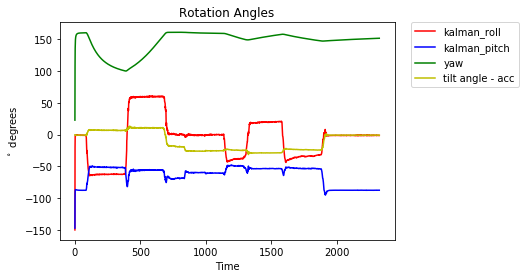

In [124]:
import matplotlib.pyplot as plt
df = vals_dfa

fig, ax = plt.subplots()

ax.plot(df['ts'], df['kalman_roll'], color='r', label='kalman_roll')
ax.plot(df['ts'], df['kalman_pitch'], color='b', label='kalman_pitch')
ax.plot(df['ts'], df['yaw'], color='g', label='yaw')
ax.plot(df['ts'], df['acc_angle_z'], color='y', label='tilt angle - acc')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Time')
ax.set_ylabel('$^\circ$ degrees')
plt.title('Rotation Angles')
plt.show(fig)

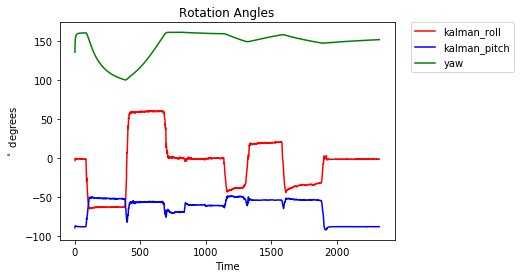

In [116]:
import matplotlib.pyplot as plt
df = vals_dfz

fig, ax = plt.subplots()

ax.plot(X3Dr[:,3], X3Dr[:,0] , color='r', label='kalman_roll')
ax.plot(X3Dr[:,3], X3Dr[:,1] , color='b', label='kalman_pitch')
ax.plot(X3Dr[:,3], X3Dr[:,2] , color='g', label='yaw')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Time')
ax.set_ylabel('$^\circ$ degrees')
plt.title('Rotation Angles')
plt.show(fig)

In [125]:
# Data, labels
import numpy as np

X2D = np.array(vals_dfz[['kalman_roll', 'kalman_pitch']])
X3D = np.array(vals_dfa[['kalman_roll', 'kalman_pitch', 'yaw', 'ts', 'zone_nbr', 'acc_angle_z']])
#y = np.array(vals_df['quad_nbr'])

In [126]:
# Remove outlier points

def rem_outliers(array):
    
    # Iteratively remove outliers, starting with z, then x, then y
    
    # Remove z outliers
    m = 10
    d = np.abs(array[:,5] - np.median(array[:,5])) # find absolute distance for yaw values from median
    mdev = np.median(d) # find median distance
    s = d/(mdev if mdev else 1.) # standard deviation calculation
    zarr = array[s<m]

    # Remove x outliers
    m = 8
    d = np.abs(zarr[:,0] - np.median(zarr[:,0])) # find absolute distance for yaw values from median
    mdev = np.median(d) # find median distance
    s = d/(mdev if mdev else 1.) # standard deviation calculation
    xarr =  array[s<m]
    
    # Remove y outliers
    m = 8
    d = np.abs(xarr[:,1] - np.median(xarr[:,1])) # find absolute distance for yaw values from median
    mdev = np.median(d) # find median distance
    s = d/(mdev if mdev else 1.) # standard deviation calculation
    farr =  array[s<m]
    
    return farr

X3Dr = rem_outliers(X3D)

In [127]:
len(X3D), len(X3Dr), len(X3D) - len(X3Dr)

(2325, 2311, 14)

In [150]:
def plot_3d_brushing(df):

    fig3d = plt.figure()
    ax = Axes3D(fig3d)

    t = np.arange(df.shape[0])
    #ax.scatter(df['kalman_roll'], df['kalman_pitch'], df['yaw'], c=df['ts'], cmap= 'Vega20')
    ax.scatter(X3Dr[:,0], X3Dr[:,1], X3Dr[:,2], c=X3Dr[:,], cmap = 'Vega20')
    m = cm.ScalarMappable(cmap='Vega20')
    m.set_array(X3Dr[:,4])
    cbar = plt.colorbar(m)
    ax.view_init(7, -80)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.title('3d view - XYZ angular position by Coach Zone Label')
    plt.show(ax)


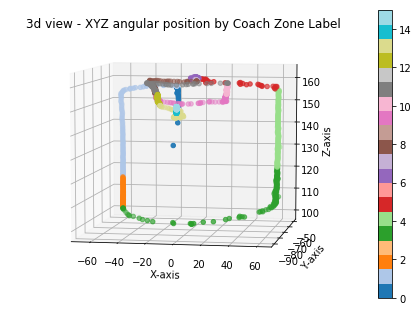

In [151]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plot_3d_brushing(vals_df)

In [134]:
zdf.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
quad_name,Up_left,Lo_left,Up_right,Lo_right,Inc_ext,Inc_ext,Up_left,Up_left,Lo_left,Lo_left,Up_right,Up_right,Lo_right,Lo_right,Inc_int,Inc_int,unknown
quad_nbr,0,1,2,3,4,4,0,0,1,1,2,2,3,3,5,5,6
zone_name,Up_mol_le_ext,Lo_mol_le_ext,Up_mol_ri_ext,Lo_mol_ri_ext,Up_inc_ext,Lo_inc_ext,Up_mol_le_occ,Up_mol_le_int,Lo_mol_le_int,Lo_mol_le_occ,Up_mol_ri_occ,Up_mol_ri_int,Lo_mol_ri_int,Lo_mol_ri_occ,Up_inc_int,Lo_inc_int,unknown
zone_nbr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16


In [157]:
def plot_2d_brushing(df):

    fig, ax = plt.subplots()

    t = np.arange(df.shape[0])
    #ax.scatter(df['kalman_roll'], df['kalman_pitch'], df['yaw'], c=df['ts'], cmap= 'Vega20')
    ax.scatter(X3Dr[:,0], X3Dr[:,1], c=X3Dr[:,3], cmap = 'Vega20')
    m = cm.ScalarMappable(cmap='Vega20')
    m.set_array(X3Dr[:,4])
    cbar = plt.colorbar(m)
    #plt.vlines(X3Dr[:,1].mean(), X3Dr[:,1].min(), X3Dr[:,1].max(), linestyle='--')
    #plt.hlines(0, -80, 50, linestyle='--')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    plt.title('2d view - XY angular position by Time')
    plt.show(ax)


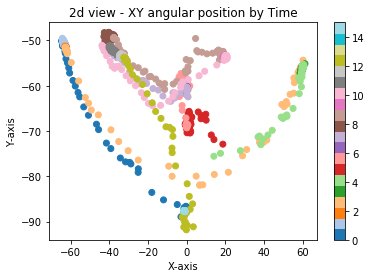

In [158]:
plot_2d_brushing(vals_df)

In [154]:
def plot_2d_brushing(df):

    fig, ax = plt.subplots()

    t = np.arange(df.shape[0])
    #ax.scatter(df['kalman_roll'], df['kalman_pitch'], df['yaw'], c=df['ts'], cmap= 'Vega20')
    ax.scatter(X3Dr[:,0], X3Dr[:,1], c=X3Dr[:,4], cmap = 'Vega20')
    m = cm.ScalarMappable(cmap='Vega20')
    m.set_array(X3Dr[:,4])
    cbar = plt.colorbar(m)
    #plt.vlines(X3Dr[:,1].mean(), X3Dr[:,1].min(), X3Dr[:,1].max(), linestyle='--')
    #plt.hlines(0, -80, 50, linestyle='--')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    plt.title('2d view - XY angular position by Coach Zone Label')
    plt.show(ax)


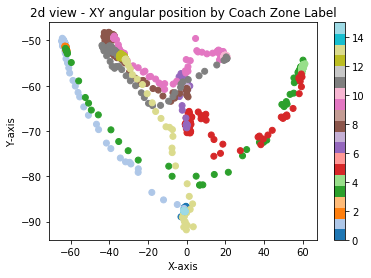

In [155]:
plot_2d_brushing(vals_df)

In [156]:
zdf.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
quad_name,Up_left,Lo_left,Up_right,Lo_right,Inc_ext,Inc_ext,Up_left,Up_left,Lo_left,Lo_left,Up_right,Up_right,Lo_right,Lo_right,Inc_int,Inc_int,unknown
quad_nbr,0,1,2,3,4,4,0,0,1,1,2,2,3,3,5,5,6
zone_name,Up_mol_le_ext,Lo_mol_le_ext,Up_mol_ri_ext,Lo_mol_ri_ext,Up_inc_ext,Lo_inc_ext,Up_mol_le_occ,Up_mol_le_int,Lo_mol_le_int,Lo_mol_le_occ,Up_mol_ri_occ,Up_mol_ri_int,Lo_mol_ri_int,Lo_mol_ri_occ,Up_inc_int,Lo_inc_int,unknown
zone_nbr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16


In [148]:
def plot_3d_brushing_time(df):

    fig3d = plt.figure()
    ax = Axes3D(fig3d)

    t = np.arange(df.shape[0])
    #ax.scatter(df['kalman_roll'], df['kalman_pitch'], df['yaw'], c=df['ts'], cmap= 'Vega20')
    ax.scatter(X3Dr[:,0], X3Dr[:,1], X3Dr[:,5], c=X3Dr[:,3], cmap = 'Vega20')
    ax.view_init(7, -80)
    m = cm.ScalarMappable(cmap='Vega20')
    m.set_array(df.ts * 0.05)
    cbar = plt.colorbar(m)
    
    
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.title('3d view - XYZ angular position by time (secs)')
    plt.show(ax)


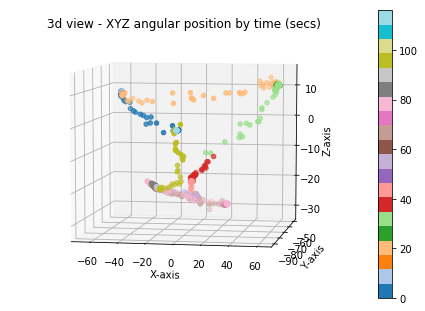

In [149]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plot_3d_brushing_time(vals_df)

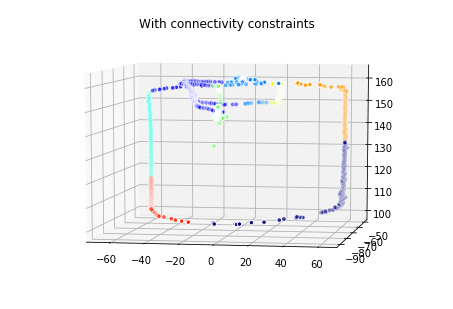

In [145]:
# Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

X = X3Dr[:,0:3]

#connectivity = kneighbors_graph(X, n_neighbors=15, include_self=False)

ward = AgglomerativeClustering(n_clusters=8,linkage='ward').fit(X)
label = ward.labels_

# Plot result
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='w')
plt.title('With connectivity constraints')

plt.show()

In [ ]:
# quivers

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make the grid
x = X3Dr[:,0]
y = X3Dr[:,1]
z = X3Dr[:,2]

# Make the direction data for the arrows
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

ax.set_xlim()

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)


plt.show()

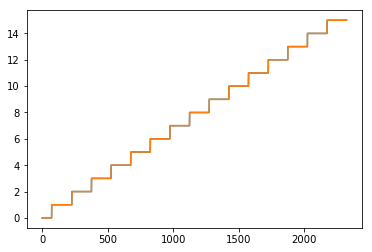

In [40]:
plt.plot(df.zone_nbr)
plt.show()